In [4]:
import sys, pandas as pd, numpy as np
print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
##versions

Python: 3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:09:58) [MSC v.1929 64 bit (AMD64)]
pandas: 2.3.3
numpy: 2.3.4


In [ ]:
import pandas as pd
import yfinance as yf

tickers = ["SPY","AGG","QQQ","EFA","EEM","VNQ","GLD","BND"]

px = yf.download(tickers, start="2015-01-01")

# --- normalize columns so they become simple ticker names ---
if isinstance(px.columns, pd.MultiIndex):
    # If first level has 'Adj Close', select that level
    if 'Adj Close' in px.columns.get_level_values(0):
        px = px.xs('Adj Close', axis=1, level=0)
    # Or if second level has 'Adj Close'
    elif 'Adj Close' in px.columns.get_level_values(1):
        px = px.xs('Adj Close', axis=1, level=1)
    else:
        # Fallback: use 'Close' if 'Adj Close' isn't present
        if 'Close' in px.columns.get_level_values(0):
            px = px.xs('Close', axis=1, level=0)
        elif 'Close' in px.columns.get_level_values(1):
            px = px.xs('Close', axis=1, level=1)
# After this, px columns should be plain tickers like 'SPY','AGG',...
px = px.dropna()
px.head()
##download prices

C:\Users\lukeb\AppData\Local\Temp\ipykernel_496\1345436468.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(tickers, start="2015-01-01")
[*********************100%***********************]  8 of 8 completed


Ticker,AGG,BND,EEM,EFA,GLD,QQQ,SPY,VNQ
Date,,,,,,,,
2015-01-02,82.515495,60.781799,30.789448,44.573959,114.080002,94.906555,171.093704,53.596222
2015-01-05,82.694809,60.958336,30.241480,43.521778,115.800003,93.514374,168.003738,53.889565
2015-01-06,82.904022,61.134838,30.114416,43.028797,117.120003,92.260521,166.421417,54.424103
2015-01-07,82.889076,61.171589,30.765631,43.507069,116.430000,93.449860,168.495193,55.258484
2015-01-08,82.762039,61.075981,31.289768,44.095684,115.940002,95.238449,171.485123,55.467064


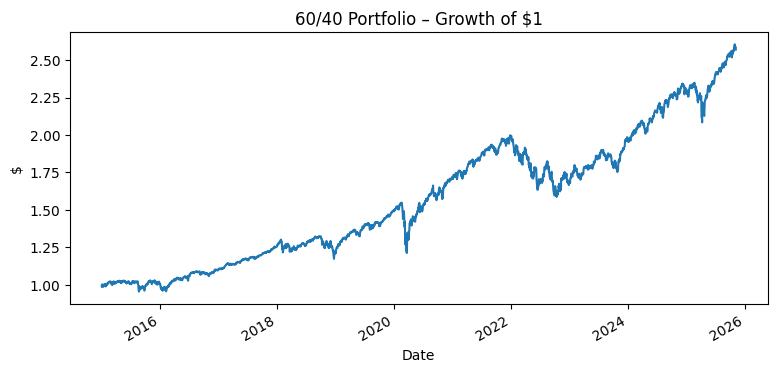

In [13]:
import numpy as np
import matplotlib.pyplot as plt

rets = px.pct_change().dropna()            # columns are tickers now

w = {"SPY":0.6, "AGG":0.4}
p60_40 = rets[list(w)].mul(pd.Series(w), axis=1).sum(1)

(1 + p60_40).cumprod().plot(figsize=(9,4), title="60/40 Portfolio – Growth of $1")
plt.ylabel("$")
plt.show()
##quick 60/40 chart

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# Helpers
def _to_series(weights, index):
    if isinstance(weights, (list, tuple, np.ndarray)):
        w = pd.Series(weights, index=index, dtype=float)
    elif isinstance(weights, dict):
        w = pd.Series(weights, dtype=float).reindex(index).fillna(0.0)
    elif isinstance(weights, pd.Series):
        w = weights.reindex(index).fillna(0.0).astype(float)
    else:
        raise TypeError("weights must be list/ndarray/tuple/dict/Series")
    s = w.sum()
    return w / s if s != 0 else w

def portfolio_return_series(weights, rets):
    cols = list(rets.columns)
    w = _to_series(weights, cols)
    return rets[cols].dot(w)

# Metrics
def annualized_return(r, periods=252):
    return float(r.mean() * periods)

def annualized_volatility(r, periods=252):
    return float(r.std(ddof=0) * np.sqrt(periods))

def sharpe_ratio(r, rf=0.0, periods=252):
    r_excess = r - (rf / periods)
    ann_excess = annualized_return(r_excess, periods)
    ann_vol = annualized_volatility(r, periods)
    return float(ann_excess / ann_vol) if ann_vol > 0 else np.nan

def max_drawdown_from_returns(r):
    wealth = (1 + r).cumprod()
    dd = wealth / wealth.cummax() - 1.0
    return float(dd.min())

def beta_vs_benchmark(r, bench):
    df = pd.concat([r, bench], axis=1).dropna()
    if df.shape[0] < 2:
        return np.nan
    cov = np.cov(df.iloc[:, 0], df.iloc[:, 1])[0, 1]
    var_b = np.var(df.iloc[:, 1])
    return float(cov / var_b) if var_b > 0 else np.nan

def compute_portfolio_metrics(weights, rets, rf=0.0, bench_ticker="SPY", periods=252):
    pr = portfolio_return_series(weights, rets)
    bench = rets.get(bench_ticker)
    return {
        "Ann. Return": annualized_return(pr, periods),
        "Ann. Vol": annualized_volatility(pr, periods),
        "Sharpe": sharpe_ratio(pr, rf, periods),
        "Max Drawdown": max_drawdown_from_returns(pr),
        "Beta vs SPY": beta_vs_benchmark(pr, bench) if bench is not None else np.nan,
    }

# Portfolios
PORTFOLIOS = {
    "60/40 (SPY/AGG)": {"SPY": 0.60, "AGG": 0.40},
    "All-Equity": {"SPY": 0.20, "QQQ": 0.20, "EFA": 0.20, "EEM": 0.20, "VNQ": 0.20},
    "Diversified Mix": {"SPY": 0.30, "EFA": 0.15, "EEM": 0.10, "VNQ": 0.10, "BND": 0.25, "GLD": 0.10},
}

# Build table
rows = []
for name, wts in PORTFOLIOS.items():
    m = compute_portfolio_metrics(wts, rets, rf=0.0, bench_ticker="SPY")
    m["Portfolio"] = name
    rows.append(m)

metrics_df = pd.DataFrame(rows).set_index("Portfolio")

# Plain display
df_fmt = metrics_df.copy()
df_fmt["Ann. Return"] = df_fmt["Ann. Return"].map("{:.2%}".format)
df_fmt["Ann. Vol"] = df_fmt["Ann. Vol"].map("{:.2%}".format)
df_fmt["Sharpe"] = df_fmt["Sharpe"].map("{:.2f}".format)
df_fmt["Max Drawdown"] = df_fmt["Max Drawdown"].map("{:.2%}".format)
df_fmt["Beta vs SPY"] = df_fmt["Beta vs SPY"].map("{:.2f}".format)
display(df_fmt)
##portfolio metrics + comparison

,Ann. Return,Ann. Vol,Sharpe,Max Drawdown,Beta vs SPY
Portfolio,,,,,
60/40 (SPY/AGG),9.35%,11.11%,0.84,-21.72%,0.61
All-Equity,11.34%,17.42%,0.65,-33.46%,0.94
Diversified Mix,8.65%,11.58%,0.75,-23.87%,0.61


Ticker,AGG,BND,EEM,EFA,GLD,QQQ,SPY,VNQ
Ticker,,,,,,,,
AGG,1.00,0.96,0.11,0.14,0.35,0.10,0.09,0.27
BND,0.96,1.00,0.11,0.14,0.34,0.11,0.11,0.28
EEM,0.11,0.11,1.00,0.83,0.17,0.72,0.75,0.55
EFA,0.14,0.14,0.83,1.00,0.14,0.76,0.85,0.66
GLD,0.35,0.34,0.17,0.14,1.00,0.05,0.04,0.13
QQQ,0.10,0.11,0.72,0.76,0.05,1.00,0.93,0.59
SPY,0.09,0.11,0.75,0.85,0.04,0.93,1.00,0.73
VNQ,0.27,0.28,0.55,0.66,0.13,0.59,0.73,1.00


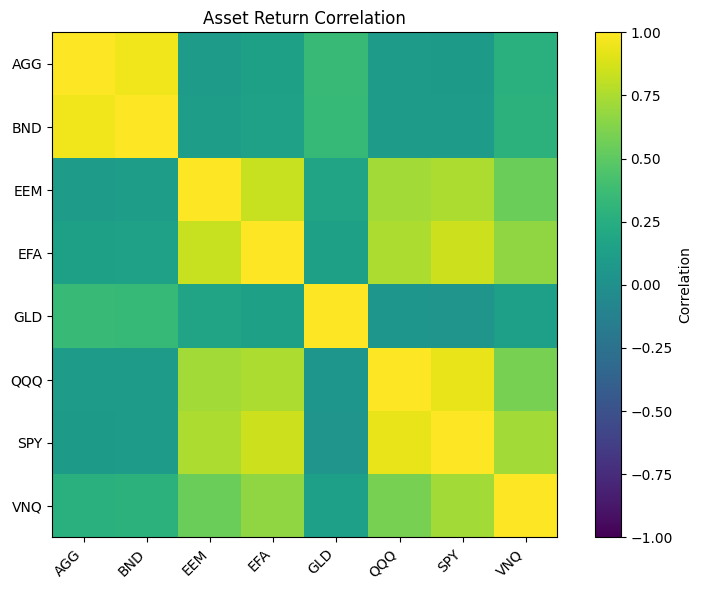

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Choose which assets to include (default: all in rets)
asset_cols = list(rets.columns)

# Compute correlation matrix on daily returns
cor_mat = rets[asset_cols].corr()

# Optional: also show the numeric table (rounded)
display(cor_mat.round(2))

# Heatmap (plain matplotlib; no extra packages required)
plt.figure(figsize=(8, 6))
# Keep a consistent scale so colors are comparable run-to-run
im = plt.imshow(cor_mat.values, interpolation="nearest", vmin=-1, vmax=1)
plt.title("Asset Return Correlation")
plt.xticks(range(len(asset_cols)), asset_cols, rotation=45, ha="right")
plt.yticks(range(len(asset_cols)), asset_cols)
plt.colorbar(im, label="Correlation")
plt.tight_layout()
plt.show()
##Correlation heatmap (assets)

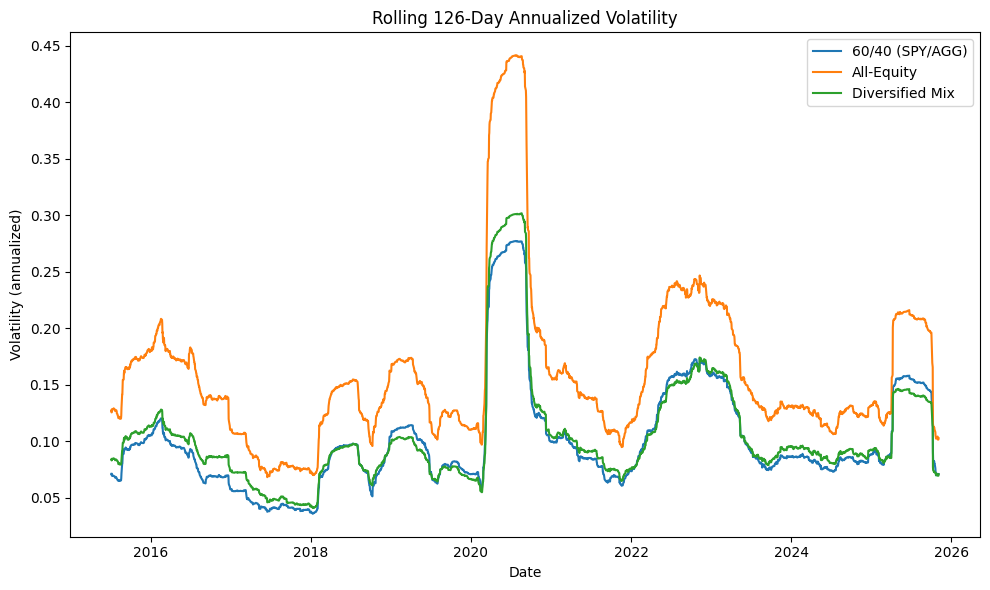

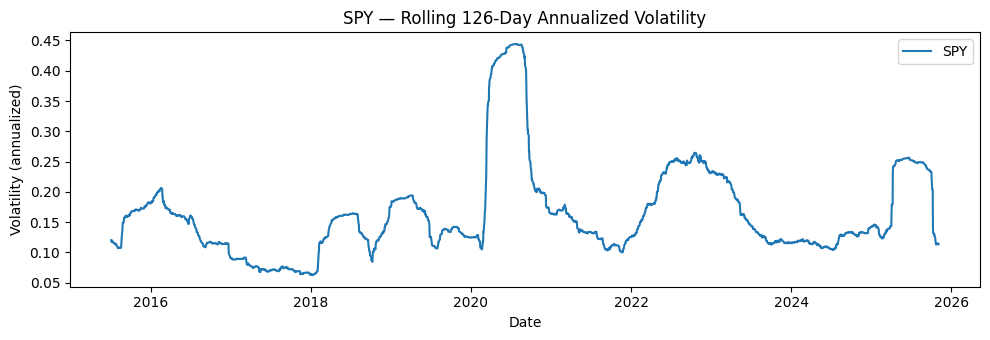

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Window length in trading days (126 ~ 6 months, 252 ~ 1 year)
ROLLING_WINDOW = 126

# Ensure we have the helper from cell 4
def _ensure_portfolio_return_series():
    try:
        portfolio_return_series  # noqa: F401
    except NameError:
        raise RuntimeError("portfolio_return_series is missing. Run Cell 4 first.")

_ensure_portfolio_return_series()

# Compute rolling vol for each defined portfolio
plt.figure(figsize=(10, 6))
for name, wts in PORTFOLIOS.items():
    pr = portfolio_return_series(wts, rets)  # daily returns of the portfolio
    rolling_vol = pr.rolling(ROLLING_WINDOW).std(ddof=0) * np.sqrt(252)  # annualized
    plt.plot(rolling_vol.index, rolling_vol.values, label=name)

plt.title(f"Rolling {ROLLING_WINDOW}-Day Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (annualized)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: include a benchmark's rolling vol (e.g., SPY) on a separate chart ---
if "SPY" in rets.columns:
    plt.figure(figsize=(10, 3.5))
    spy_roll = rets["SPY"].rolling(ROLLING_WINDOW).std(ddof=0) * np.sqrt(252)
    plt.plot(spy_roll.index, spy_roll.values, label="SPY", linewidth=1.5)
    plt.title(f"SPY — Rolling {ROLLING_WINDOW}-Day Annualized Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility (annualized)")
    plt.legend()
    plt.tight_layout()
    plt.show()
##Rolling annualized volatility (portfolios)

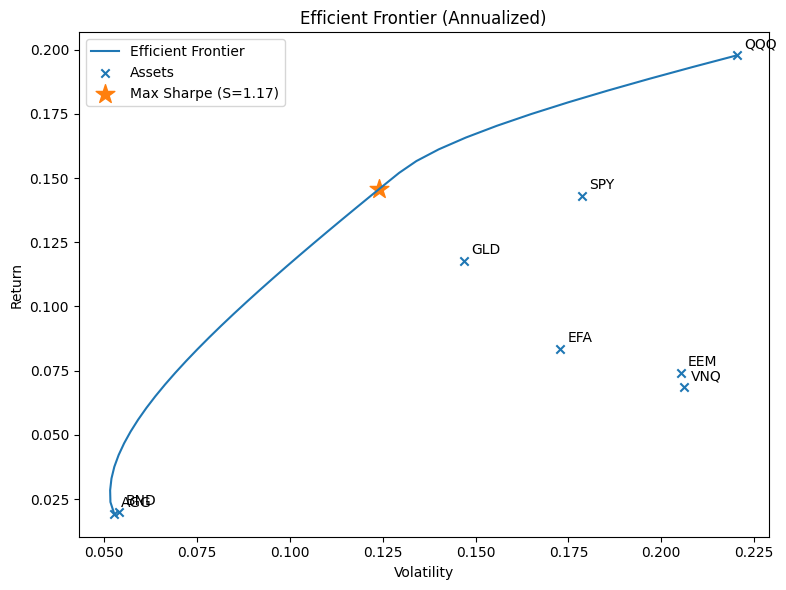

BND     4.98%
GLD    53.94%
QQQ    41.08%
Name: Weight, dtype: object

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

# Choose which assets to include in optimization
universe = [t for t in rets.columns if t in ["SPY","QQQ","EFA","EEM","VNQ","BND","AGG","GLD"]]

# Estimate annualized mean and covariance
mu_daily = rets[universe].mean()
cov_daily = rets[universe].cov()
mu = mu_daily * 252
cov = cov_daily * 252

def portfolio_stats(w, mu, cov, rf=0.0):
    """Return (return, vol, sharpe) for weight vector."""
    w = np.array(w)
    r = float(w @ mu.values)
    v = float(np.sqrt(w @ cov.values @ w))
    s = (r - rf) / v if v > 0 else np.nan
    return r, v, s

def minimize_vol_for_target(mu, cov, target_ret, bounds):
    n = len(mu)
    x0 = np.repeat(1/n, n)
    cons = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu.values - target_ret},
    )
    return optimize.minimize(
        fun=lambda w: np.sqrt(w @ cov.values @ w),
        x0=x0, method="SLSQP", bounds=bounds, constraints=cons,
        options={"maxiter": 500, "ftol": 1e-9}
    )

def max_sharpe(mu, cov, rf=0.0, bounds=None):
    n = len(mu)
    if bounds is None:
        bounds = [(0.0, 1.0)] * n
    x0 = np.repeat(1/n, n)
    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1},)
    def neg_sharpe(w):
        _, _, s = portfolio_stats(w, mu, cov, rf)
        return -s
    return optimize.minimize(neg_sharpe, x0=x0, bounds=bounds, constraints=cons, method="SLSQP")

# Bounds: long-only
bounds = [(0.0, 1.0)] * len(mu)

# Build efficient frontier
ret_targets = np.linspace(mu.min(), mu.max(), 40)
frontier = []
for tr in ret_targets:
    res = minimize_vol_for_target(mu, cov, tr, bounds)
    if res.success:
        r, v, _ = portfolio_stats(res.x, mu, cov)
        frontier.append((r, v))
frontier = np.array(frontier)

# Max Sharpe portfolio
rf = 0.0
res_ms = max_sharpe(mu, cov, rf, bounds)
ms_r, ms_v, ms_s = portfolio_stats(res_ms.x, mu, cov, rf) if res_ms.success else (np.nan, np.nan, np.nan)

# Plot
plt.figure(figsize=(8, 6))
if len(frontier) > 0:
    plt.plot(frontier[:, 1], frontier[:, 0], label="Efficient Frontier")
asset_vol = np.sqrt(np.diag(cov.values))
asset_ret = mu.values
plt.scatter(asset_vol, asset_ret, marker="x", label="Assets")
for i, t in enumerate(universe):
    plt.annotate(t, (asset_vol[i], asset_ret[i]), xytext=(5, 5), textcoords="offset points")
if res_ms.success:
    plt.scatter(ms_v, ms_r, marker="*", s=200, label=f"Max Sharpe (S={ms_s:.2f})")
plt.title("Efficient Frontier (Annualized)")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

# Show Max Sharpe weights
if res_ms.success:
    ms_weights = pd.Series(res_ms.x, index=universe, name="Weight")
    ms_weights = ms_weights[ms_weights > 1e-6]
    display(ms_weights.apply(lambda x: f"{x:.2%}"))

##Efficient Frontier and Max Sharpe Portfolio 

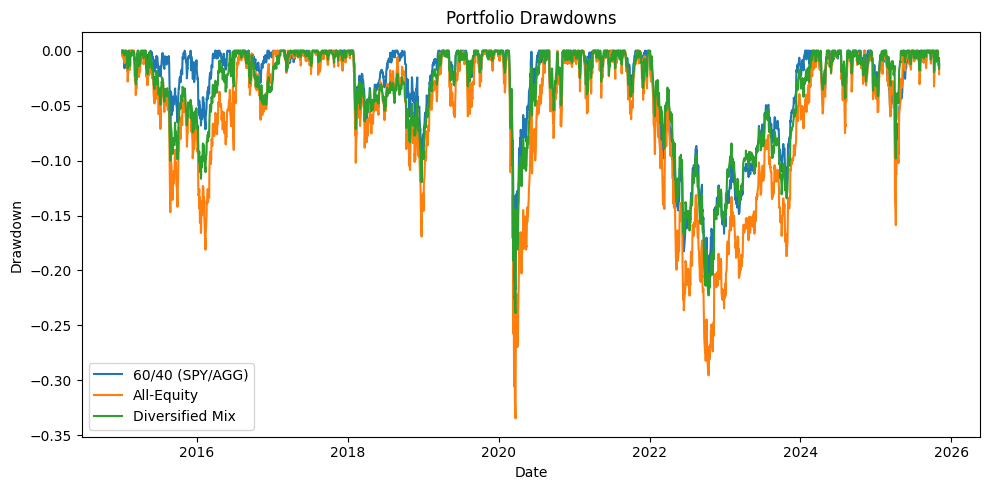

,Max Drawdown,Peak,Trough
Portfolio,,,
60/40 (SPY/AGG),-21.72%,2020-02-19,2020-03-23
All-Equity,-33.46%,2020-02-12,2020-03-23
Diversified Mix,-23.87%,2020-02-19,2020-03-23


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure helpers/portfolios exist from Cell 4
def _ensure_prereqs():
    try:
        portfolio_return_series  # noqa: F401
        PORTFOLIOS               # noqa: F401
    except NameError:
        raise RuntimeError("Missing helpers or portfolios. Run Cell 4 first.")
_ensure_prereqs()

def compute_drawdown(r: pd.Series) -> pd.Series:
    """Return drawdown series from a daily return series (simple returns)."""
    wealth = (1 + r).cumprod()
    peak = wealth.cummax()
    return wealth / peak - 1.0

# Plot drawdowns for each portfolio
plt.figure(figsize=(10, 5))
dd_last = {}
for name, wts in PORTFOLIOS.items():
    pr = portfolio_return_series(wts, rets)
    dd = compute_drawdown(pr)
    dd_last[name] = dd.iloc[-1] if not dd.empty else np.nan
    plt.plot(dd.index, dd.values, label=name)

plt.title("Portfolio Drawdowns")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: show a small summary table of worst drawdown for each portfolio
summary_rows = []
for name, wts in PORTFOLIOS.items():
    pr = portfolio_return_series(wts, rets)
    dd = compute_drawdown(pr)
    worst = dd.min() if not dd.empty else np.nan
    # locate period of worst drawdown
    if not dd.empty and np.isfinite(worst):
        trough_date = dd.idxmin()
        # find the peak just before the trough
        wealth = (1 + pr).cumprod()
        peak = wealth[:trough_date].idxmax()
        summary_rows.append({"Portfolio": name, "Max Drawdown": worst, "Peak": peak, "Trough": trough_date})
    else:
        summary_rows.append({"Portfolio": name, "Max Drawdown": np.nan, "Peak": pd.NaT, "Trough": pd.NaT})

dd_table = pd.DataFrame(summary_rows).set_index("Portfolio")
dd_table_fmt = dd_table.copy()
dd_table_fmt["Max Drawdown"] = dd_table_fmt["Max Drawdown"].map(lambda x: f"{x:.2%}" if pd.notnull(x) else "—")
display(dd_table_fmt)
##Portfolio drawdowns (overlay)

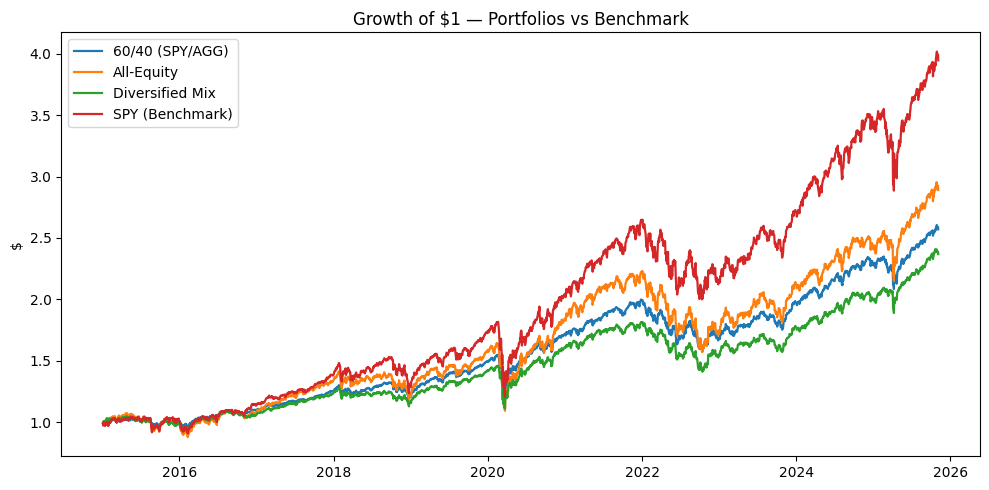

,Ann. Return,Ann. Vol,Sharpe,Max Drawdown,Beta vs SPY
Portfolio,,,,,
60/40 (SPY/AGG),9.35%,11.11%,0.84,-21.72%,0.61
Diversified Mix,8.65%,11.58%,0.75,-23.87%,0.61
All-Equity,11.34%,17.42%,0.65,-33.46%,0.94


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- safety checks (run Cell 4 first) ---
def _ensure_prereqs_final():
    try:
        portfolio_return_series  # from Cell 4
        PORTFOLIOS               # from Cell 4
        rets                     # from earlier cells
    except NameError:
        raise RuntimeError("Missing prereqs. Run Cells 2–4 first.")
_ensure_prereqs_final()

# --- 1) Growth of $1 for each portfolio (and optional benchmark) ---
wealth_curves = {}
for name, wts in PORTFOLIOS.items():
    pr = portfolio_return_series(wts, rets)
    wealth_curves[name] = (1 + pr).cumprod()

# Add benchmark (SPY) for reference if present
if "SPY" in rets.columns:
    wealth_curves["SPY (Benchmark)"] = (1 + rets["SPY"]).cumprod()

wealth_df = pd.DataFrame(wealth_curves).dropna(how="all")

plt.figure(figsize=(10, 5))
for col in wealth_df.columns:
    plt.plot(wealth_df.index, wealth_df[col].values, label=col, linewidth=1.6)
plt.title("Growth of $1 — Portfolios vs Benchmark")
plt.ylabel("$")
plt.legend()
plt.tight_layout()
plt.show()

# --- 2) Recompute metrics and show a sorted summary (by Sharpe) ---
def annualized_return(r, periods=252): return float(r.mean() * periods)
def annualized_volatility(r, periods=252): return float(r.std(ddof=0) * np.sqrt(periods))
def sharpe_ratio(r, rf=0.0, periods=252):
    r_excess = r - (rf / periods)
    ann_excess = annualized_return(r_excess, periods)
    ann_vol = annualized_volatility(r, periods)
    return float(ann_excess / ann_vol) if ann_vol > 0 else np.nan
def max_drawdown_from_returns(r):
    wealth = (1 + r).cumprod()
    return float((wealth / wealth.cummax() - 1.0).min())
def beta_vs_benchmark(r, bench):
    df = pd.concat([r, bench], axis=1).dropna()
    if df.shape[0] < 2: return np.nan
    cov = np.cov(df.iloc[:, 0], df.iloc[:, 1])[0, 1]
    var_b = np.var(df.iloc[:, 1])
    return float(cov / var_b) if var_b > 0 else np.nan

rows = []
bench = rets.get("SPY")
for name, wts in PORTFOLIOS.items():
    pr = portfolio_return_series(wts, rets)
    rows.append({
        "Portfolio": name,
        "Ann. Return": annualized_return(pr),
        "Ann. Vol": annualized_volatility(pr),
        "Sharpe": sharpe_ratio(pr, rf=0.0),
        "Max Drawdown": max_drawdown_from_returns(pr),
        "Beta vs SPY": beta_vs_benchmark(pr, bench) if bench is not None else np.nan,
    })

summary_df = pd.DataFrame(rows).set_index("Portfolio").sort_values("Sharpe", ascending=False)

# Plain, nicely formatted table
out = summary_df.copy()
out["Ann. Return"] = out["Ann. Return"].map("{:.2%}".format)
out["Ann. Vol"]     = out["Ann. Vol"].map("{:.2%}".format)
out["Sharpe"]       = out["Sharpe"].map("{:.2f}".format)
out["Max Drawdown"] = out["Max Drawdown"].map("{:.2%}".format)
out["Beta vs SPY"]  = out["Beta vs SPY"].map("{:.2f}".format)
display(out)

# Save outputs
SAVE_OUTPUTS = False  # set True to write files
if SAVE_OUTPUTS:
    summary_df.to_csv("portfolio_metrics_summary.csv", index=True)
    wealth_df.to_csv("wealth_curves.csv", index=True)
    print("Saved: portfolio_metrics_summary.csv, wealth_curves.csv")

# === Done! ===

##Final Summary — Growth of $1 + Key Metrics